# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

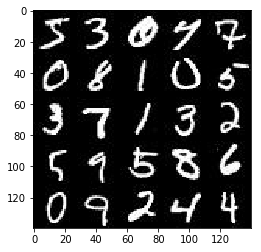

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

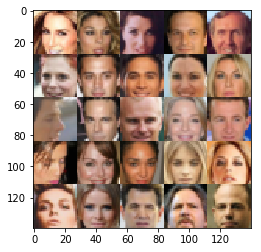

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    placeholder_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    placeholder_z_data = tf.placeholder(tf.float32, (None, z_dim))
    placeholder_learning_rate = tf.placeholder(tf.float32)

    return placeholder_images, placeholder_z_data, placeholder_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [102]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input layer is 28x28x3
                
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)    
        # 7x7x128       

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)        
        # 2x2x256

        # Flatten it
        flat = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [106]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    alpha = 0.2
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
                    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [95]:
train_show_every = 100
train_print_every = 10

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
            
    steps = 0
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)        
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
            
    with tf.Session() as sess:        
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Rescale to [-1; 1] for tanh.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})                
                
                if steps % train_print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
    
                if steps % train_show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Discriminator Loss: 0.8466... Generator Loss: 0.8396
Discriminator Loss: 0.1186... Generator Loss: 4.4269
Discriminator Loss: 0.0889... Generator Loss: 4.9031
Discriminator Loss: 0.1493... Generator Loss: 2.2855
Discriminator Loss: 0.1313... Generator Loss: 3.0248
Discriminator Loss: 0.8177... Generator Loss: 0.7102
Discriminator Loss: 0.1747... Generator Loss: 5.2484
Discriminator Loss: 0.0844... Generator Loss: 3.0330
Discriminator Loss: 0.3871... Generator Loss: 1.3989
Discriminator Loss: 1.6477... Generator Loss: 0.2751


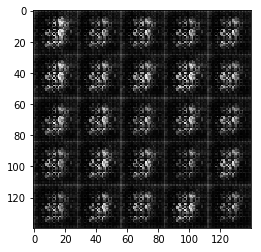

Discriminator Loss: 0.6597... Generator Loss: 1.0370
Discriminator Loss: 0.2682... Generator Loss: 2.1935
Discriminator Loss: 0.2524... Generator Loss: 2.2330
Discriminator Loss: 0.1626... Generator Loss: 3.2221
Discriminator Loss: 0.2225... Generator Loss: 2.3660
Discriminator Loss: 0.4191... Generator Loss: 1.6939
Discriminator Loss: 0.2580... Generator Loss: 2.4922
Discriminator Loss: 0.5824... Generator Loss: 1.6116
Discriminator Loss: 0.5163... Generator Loss: 1.7416
Discriminator Loss: 0.4628... Generator Loss: 1.5733


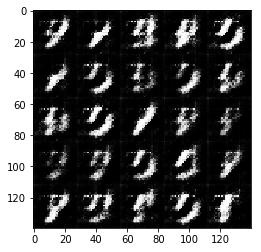

Discriminator Loss: 0.3129... Generator Loss: 2.1559
Discriminator Loss: 0.6077... Generator Loss: 1.3085
Discriminator Loss: 0.5102... Generator Loss: 1.6361
Discriminator Loss: 0.4794... Generator Loss: 2.2797
Discriminator Loss: 0.7144... Generator Loss: 1.2663
Discriminator Loss: 0.2618... Generator Loss: 2.9674
Discriminator Loss: 0.5475... Generator Loss: 1.3485
Discriminator Loss: 0.7038... Generator Loss: 1.2827
Discriminator Loss: 0.4408... Generator Loss: 2.0786
Discriminator Loss: 0.3444... Generator Loss: 2.0430


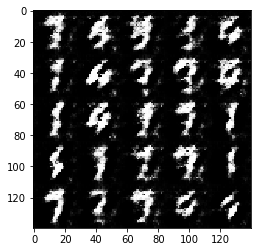

Discriminator Loss: 0.4687... Generator Loss: 2.0581
Discriminator Loss: 0.6418... Generator Loss: 1.5890
Discriminator Loss: 0.5421... Generator Loss: 1.8126
Discriminator Loss: 0.7046... Generator Loss: 1.1192
Discriminator Loss: 0.9258... Generator Loss: 0.8742
Discriminator Loss: 0.6089... Generator Loss: 1.4540
Discriminator Loss: 0.7285... Generator Loss: 0.9367
Discriminator Loss: 0.6176... Generator Loss: 2.3681
Discriminator Loss: 0.5353... Generator Loss: 1.3005
Discriminator Loss: 1.1722... Generator Loss: 0.6059


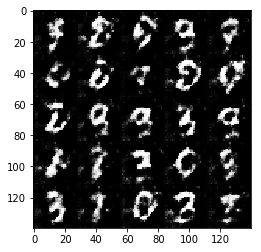

Discriminator Loss: 0.7944... Generator Loss: 1.0445
Discriminator Loss: 0.4702... Generator Loss: 1.8660
Discriminator Loss: 0.7080... Generator Loss: 1.3368
Discriminator Loss: 1.0320... Generator Loss: 1.0806
Discriminator Loss: 0.7009... Generator Loss: 1.2980
Discriminator Loss: 0.6507... Generator Loss: 1.7395
Discriminator Loss: 0.6910... Generator Loss: 1.5954
Discriminator Loss: 0.8663... Generator Loss: 1.5793
Discriminator Loss: 0.6886... Generator Loss: 1.4176
Discriminator Loss: 0.8097... Generator Loss: 1.3483


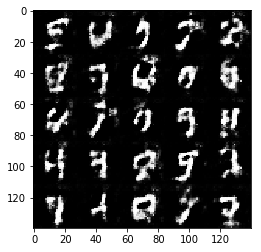

Discriminator Loss: 0.7383... Generator Loss: 1.0979
Discriminator Loss: 0.6010... Generator Loss: 1.7380
Discriminator Loss: 0.7489... Generator Loss: 1.1988
Discriminator Loss: 0.7077... Generator Loss: 1.0148
Discriminator Loss: 1.1492... Generator Loss: 2.5231
Discriminator Loss: 0.7382... Generator Loss: 1.1986
Discriminator Loss: 0.9001... Generator Loss: 0.7768
Discriminator Loss: 0.8615... Generator Loss: 1.4132
Discriminator Loss: 0.6907... Generator Loss: 1.2754
Discriminator Loss: 0.8442... Generator Loss: 1.3701


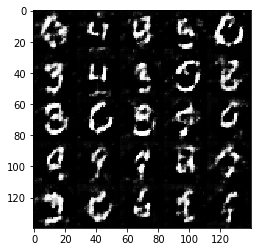

Discriminator Loss: 0.6592... Generator Loss: 1.3726
Discriminator Loss: 0.6584... Generator Loss: 1.1239
Discriminator Loss: 1.0730... Generator Loss: 0.7893
Discriminator Loss: 0.6368... Generator Loss: 2.0150
Discriminator Loss: 0.6188... Generator Loss: 1.4469
Discriminator Loss: 0.6330... Generator Loss: 1.2627
Discriminator Loss: 0.8591... Generator Loss: 2.1853
Discriminator Loss: 0.7203... Generator Loss: 1.8595
Discriminator Loss: 0.8644... Generator Loss: 1.0112
Discriminator Loss: 0.6844... Generator Loss: 1.0987


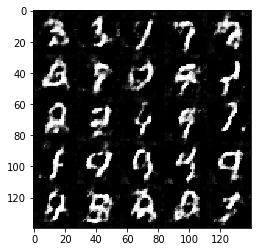

Discriminator Loss: 1.0256... Generator Loss: 0.6771
Discriminator Loss: 0.7564... Generator Loss: 1.5832
Discriminator Loss: 0.6959... Generator Loss: 1.4753
Discriminator Loss: 0.6750... Generator Loss: 1.1063
Discriminator Loss: 0.7546... Generator Loss: 2.0626
Discriminator Loss: 0.5843... Generator Loss: 1.9877
Discriminator Loss: 0.8585... Generator Loss: 1.7235
Discriminator Loss: 0.8259... Generator Loss: 1.1948
Discriminator Loss: 0.6064... Generator Loss: 1.5168
Discriminator Loss: 1.1687... Generator Loss: 0.5373


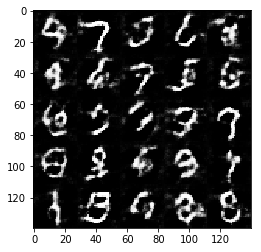

Discriminator Loss: 0.5691... Generator Loss: 1.7962
Discriminator Loss: 0.6839... Generator Loss: 1.1841
Discriminator Loss: 1.2890... Generator Loss: 0.4410
Discriminator Loss: 0.5955... Generator Loss: 1.4179
Discriminator Loss: 0.8699... Generator Loss: 1.2630
Discriminator Loss: 0.9020... Generator Loss: 1.0021
Discriminator Loss: 0.8926... Generator Loss: 0.8584
Discriminator Loss: 1.7070... Generator Loss: 0.2747
Discriminator Loss: 0.7930... Generator Loss: 0.9030
Discriminator Loss: 0.6218... Generator Loss: 1.5563


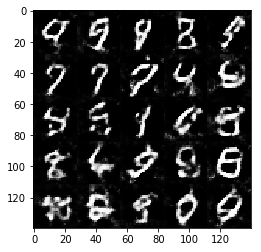

Discriminator Loss: 0.6766... Generator Loss: 1.2769
Discriminator Loss: 0.7009... Generator Loss: 1.5909
Discriminator Loss: 0.7475... Generator Loss: 1.1997
Discriminator Loss: 0.8517... Generator Loss: 1.1816
Discriminator Loss: 0.8833... Generator Loss: 1.2816
Discriminator Loss: 0.6513... Generator Loss: 1.4094
Discriminator Loss: 1.1860... Generator Loss: 0.5580
Discriminator Loss: 0.9063... Generator Loss: 1.8016
Discriminator Loss: 0.7781... Generator Loss: 1.0246
Discriminator Loss: 0.7620... Generator Loss: 0.9260


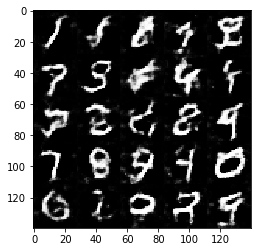

Discriminator Loss: 0.9004... Generator Loss: 1.0510
Discriminator Loss: 0.7237... Generator Loss: 1.2763
Discriminator Loss: 1.0806... Generator Loss: 0.5460
Discriminator Loss: 0.8517... Generator Loss: 0.9119
Discriminator Loss: 0.6866... Generator Loss: 1.6295
Discriminator Loss: 0.7752... Generator Loss: 0.9200
Discriminator Loss: 0.7033... Generator Loss: 1.1498
Discriminator Loss: 0.8751... Generator Loss: 0.9633
Discriminator Loss: 0.6539... Generator Loss: 1.0337
Discriminator Loss: 1.0031... Generator Loss: 0.7024


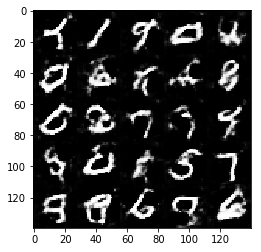

Discriminator Loss: 1.2471... Generator Loss: 0.4839
Discriminator Loss: 0.7180... Generator Loss: 1.3874
Discriminator Loss: 0.8039... Generator Loss: 0.9837
Discriminator Loss: 1.0298... Generator Loss: 0.7595
Discriminator Loss: 0.7052... Generator Loss: 1.5754
Discriminator Loss: 0.8969... Generator Loss: 0.7987
Discriminator Loss: 0.8835... Generator Loss: 1.0061
Discriminator Loss: 0.6374... Generator Loss: 1.1134
Discriminator Loss: 0.6909... Generator Loss: 1.0837
Discriminator Loss: 0.6296... Generator Loss: 1.8709


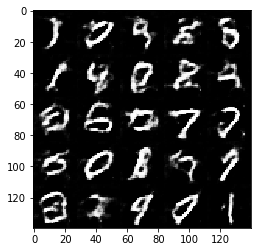

Discriminator Loss: 0.7435... Generator Loss: 1.8032
Discriminator Loss: 0.6448... Generator Loss: 1.2054
Discriminator Loss: 0.8729... Generator Loss: 0.9649
Discriminator Loss: 0.8232... Generator Loss: 1.4576
Discriminator Loss: 0.8393... Generator Loss: 1.7293
Discriminator Loss: 0.6599... Generator Loss: 1.9273
Discriminator Loss: 0.9113... Generator Loss: 1.0241
Discriminator Loss: 0.6141... Generator Loss: 2.0479
Discriminator Loss: 0.9090... Generator Loss: 0.8542
Discriminator Loss: 0.9138... Generator Loss: 0.7997


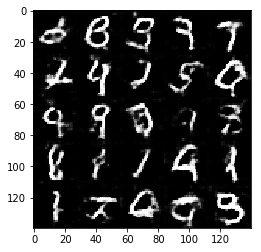

Discriminator Loss: 0.6086... Generator Loss: 2.0188
Discriminator Loss: 0.9634... Generator Loss: 0.7720
Discriminator Loss: 0.8316... Generator Loss: 1.3097
Discriminator Loss: 0.7126... Generator Loss: 1.1517
Discriminator Loss: 0.7496... Generator Loss: 1.1598
Discriminator Loss: 1.3039... Generator Loss: 0.4357
Discriminator Loss: 0.7484... Generator Loss: 0.9100
Discriminator Loss: 0.7037... Generator Loss: 1.4732
Discriminator Loss: 0.4767... Generator Loss: 1.6970
Discriminator Loss: 0.9716... Generator Loss: 0.8993


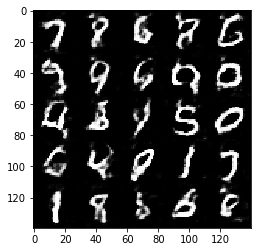

Discriminator Loss: 0.6099... Generator Loss: 1.1739
Discriminator Loss: 0.8117... Generator Loss: 1.4087
Discriminator Loss: 0.7465... Generator Loss: 1.2669
Discriminator Loss: 1.0684... Generator Loss: 0.6108
Discriminator Loss: 0.8323... Generator Loss: 0.8841
Discriminator Loss: 0.6962... Generator Loss: 1.2013
Discriminator Loss: 1.2660... Generator Loss: 0.4290
Discriminator Loss: 0.7358... Generator Loss: 0.9338
Discriminator Loss: 1.1793... Generator Loss: 0.5263
Discriminator Loss: 0.5185... Generator Loss: 1.8874


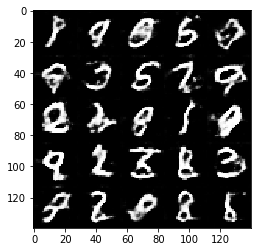

Discriminator Loss: 1.4159... Generator Loss: 0.3579
Discriminator Loss: 0.7173... Generator Loss: 1.3488
Discriminator Loss: 0.7238... Generator Loss: 0.9761
Discriminator Loss: 0.7982... Generator Loss: 1.0169
Discriminator Loss: 0.8553... Generator Loss: 0.7869
Discriminator Loss: 0.9503... Generator Loss: 0.6854
Discriminator Loss: 0.8797... Generator Loss: 1.9493
Discriminator Loss: 0.8425... Generator Loss: 1.7041
Discriminator Loss: 0.5075... Generator Loss: 1.6720
Discriminator Loss: 0.9414... Generator Loss: 0.7021


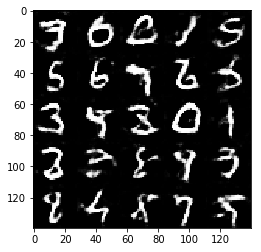

Discriminator Loss: 1.1033... Generator Loss: 0.5262
Discriminator Loss: 0.7354... Generator Loss: 1.3268
Discriminator Loss: 0.5920... Generator Loss: 1.8076
Discriminator Loss: 0.6371... Generator Loss: 1.6000
Discriminator Loss: 0.6717... Generator Loss: 1.0644
Discriminator Loss: 0.6467... Generator Loss: 1.1301
Discriminator Loss: 0.9537... Generator Loss: 0.7049
Discriminator Loss: 0.3500... Generator Loss: 1.8542
Discriminator Loss: 0.7887... Generator Loss: 0.8197
Discriminator Loss: 0.7036... Generator Loss: 1.0017


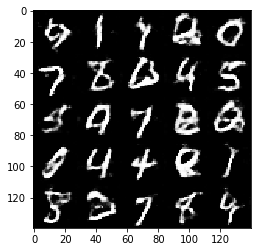

Discriminator Loss: 0.6158... Generator Loss: 1.5959
Discriminator Loss: 0.7925... Generator Loss: 2.7854
Discriminator Loss: 1.1246... Generator Loss: 0.7184
Discriminator Loss: 0.8580... Generator Loss: 0.8798
Discriminator Loss: 0.6268... Generator Loss: 1.9676
Discriminator Loss: 0.5120... Generator Loss: 1.5489
Discriminator Loss: 0.7284... Generator Loss: 1.7769
Discriminator Loss: 0.6520... Generator Loss: 1.2176
Discriminator Loss: 0.5282... Generator Loss: 1.2740
Discriminator Loss: 0.4459... Generator Loss: 1.6093


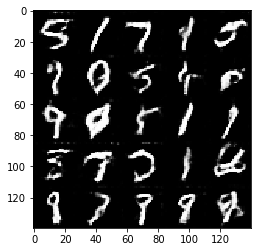

Discriminator Loss: 0.7214... Generator Loss: 1.5105
Discriminator Loss: 0.6314... Generator Loss: 1.0027
Discriminator Loss: 0.7593... Generator Loss: 1.0375
Discriminator Loss: 0.7075... Generator Loss: 0.9503
Discriminator Loss: 0.8111... Generator Loss: 0.9417
Discriminator Loss: 0.6797... Generator Loss: 1.2751
Discriminator Loss: 0.5533... Generator Loss: 1.2286
Discriminator Loss: 0.5629... Generator Loss: 1.7600
Discriminator Loss: 0.5303... Generator Loss: 1.4512
Discriminator Loss: 0.5824... Generator Loss: 1.2237


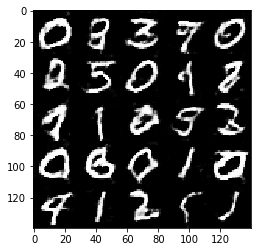

Discriminator Loss: 0.5654... Generator Loss: 1.5172
Discriminator Loss: 0.6498... Generator Loss: 1.2521
Discriminator Loss: 1.0538... Generator Loss: 0.6641
Discriminator Loss: 0.8242... Generator Loss: 0.8662
Discriminator Loss: 0.6865... Generator Loss: 1.1557
Discriminator Loss: 0.7140... Generator Loss: 0.9811
Discriminator Loss: 1.1176... Generator Loss: 0.4896
Discriminator Loss: 0.6186... Generator Loss: 1.0746
Discriminator Loss: 0.6023... Generator Loss: 1.1942
Discriminator Loss: 0.5008... Generator Loss: 1.4313


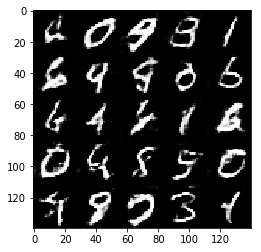

Discriminator Loss: 0.8362... Generator Loss: 0.8994
Discriminator Loss: 0.5445... Generator Loss: 1.3806
Discriminator Loss: 0.5676... Generator Loss: 1.2295
Discriminator Loss: 0.5113... Generator Loss: 1.3651
Discriminator Loss: 0.8062... Generator Loss: 0.8141
Discriminator Loss: 0.5075... Generator Loss: 1.2938
Discriminator Loss: 0.5777... Generator Loss: 1.2591
Discriminator Loss: 1.7440... Generator Loss: 0.2493
Discriminator Loss: 0.5354... Generator Loss: 1.6907
Discriminator Loss: 0.6254... Generator Loss: 2.3130


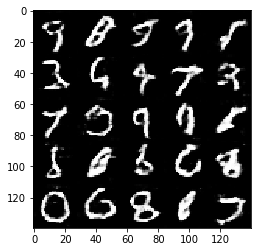

Discriminator Loss: 0.7840... Generator Loss: 0.8777
Discriminator Loss: 0.6947... Generator Loss: 1.3386
Discriminator Loss: 0.4845... Generator Loss: 1.4944
Discriminator Loss: 0.6301... Generator Loss: 1.6626
Discriminator Loss: 1.1029... Generator Loss: 0.6361
Discriminator Loss: 0.6901... Generator Loss: 0.9194
Discriminator Loss: 1.8992... Generator Loss: 0.2676
Discriminator Loss: 0.7910... Generator Loss: 0.9124
Discriminator Loss: 0.4799... Generator Loss: 1.5921
Discriminator Loss: 0.7157... Generator Loss: 0.9712


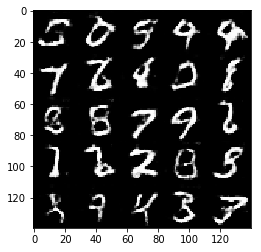

Discriminator Loss: 0.5988... Generator Loss: 1.8077
Discriminator Loss: 0.6407... Generator Loss: 1.1122
Discriminator Loss: 1.0738... Generator Loss: 0.5943
Discriminator Loss: 1.0160... Generator Loss: 0.8338
Discriminator Loss: 0.9620... Generator Loss: 0.7035
Discriminator Loss: 0.5359... Generator Loss: 1.2961
Discriminator Loss: 0.6411... Generator Loss: 1.2978
Discriminator Loss: 0.3061... Generator Loss: 2.1164
Discriminator Loss: 1.2265... Generator Loss: 0.5508
Discriminator Loss: 0.7440... Generator Loss: 0.9512


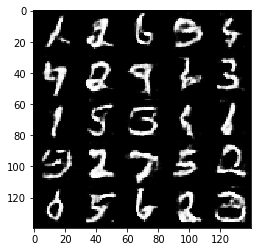

Discriminator Loss: 0.6186... Generator Loss: 1.5258
Discriminator Loss: 0.7438... Generator Loss: 0.9506
Discriminator Loss: 0.8177... Generator Loss: 0.9307
Discriminator Loss: 0.8608... Generator Loss: 0.9995
Discriminator Loss: 0.8528... Generator Loss: 1.0819
Discriminator Loss: 0.9280... Generator Loss: 0.7619
Discriminator Loss: 0.5761... Generator Loss: 1.7139
Discriminator Loss: 0.7706... Generator Loss: 1.0162
Discriminator Loss: 0.7345... Generator Loss: 0.9261
Discriminator Loss: 0.7660... Generator Loss: 0.9361


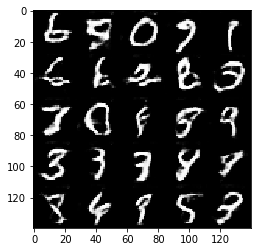

Discriminator Loss: 0.9651... Generator Loss: 0.6935
Discriminator Loss: 0.6801... Generator Loss: 1.1923
Discriminator Loss: 0.7502... Generator Loss: 0.8675
Discriminator Loss: 0.6635... Generator Loss: 1.1509
Discriminator Loss: 1.2415... Generator Loss: 0.5490
Discriminator Loss: 0.8096... Generator Loss: 0.9198
Discriminator Loss: 1.5279... Generator Loss: 0.3349
Discriminator Loss: 0.7631... Generator Loss: 0.8531
Discriminator Loss: 0.8415... Generator Loss: 0.8762
Discriminator Loss: 1.0407... Generator Loss: 0.6758


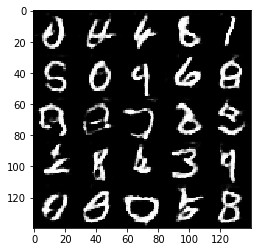

Discriminator Loss: 1.3056... Generator Loss: 0.4628
Discriminator Loss: 1.0038... Generator Loss: 2.4894
Discriminator Loss: 0.7112... Generator Loss: 0.9133
Discriminator Loss: 0.8229... Generator Loss: 0.9780
Discriminator Loss: 0.8253... Generator Loss: 0.8893
Discriminator Loss: 0.6028... Generator Loss: 1.2959
Discriminator Loss: 0.6149... Generator Loss: 1.0608
Discriminator Loss: 0.6815... Generator Loss: 1.0379
Discriminator Loss: 0.6937... Generator Loss: 1.2699
Discriminator Loss: 0.6820... Generator Loss: 1.2547


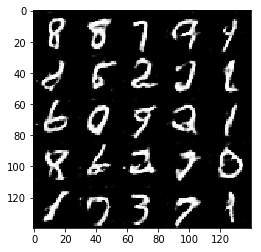

Discriminator Loss: 0.6147... Generator Loss: 1.1191
Discriminator Loss: 0.6830... Generator Loss: 1.0235
Discriminator Loss: 0.5648... Generator Loss: 1.3840
Discriminator Loss: 0.9155... Generator Loss: 0.7887
Discriminator Loss: 0.7169... Generator Loss: 1.0271
Discriminator Loss: 1.1984... Generator Loss: 0.5713
Discriminator Loss: 1.0104... Generator Loss: 0.6291
Discriminator Loss: 0.4403... Generator Loss: 1.7743
Discriminator Loss: 0.5489... Generator Loss: 1.2910
Discriminator Loss: 0.8026... Generator Loss: 0.8560


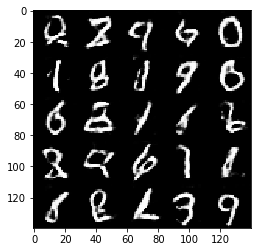

Discriminator Loss: 0.3535... Generator Loss: 1.8574
Discriminator Loss: 0.8510... Generator Loss: 0.8505
Discriminator Loss: 1.5679... Generator Loss: 0.3697
Discriminator Loss: 0.8692... Generator Loss: 0.7713
Discriminator Loss: 0.6753... Generator Loss: 1.0442
Discriminator Loss: 0.5297... Generator Loss: 1.2691
Discriminator Loss: 0.4813... Generator Loss: 1.7886
Discriminator Loss: 0.5102... Generator Loss: 1.3321
Discriminator Loss: 1.0232... Generator Loss: 0.6090
Discriminator Loss: 0.7604... Generator Loss: 0.8463


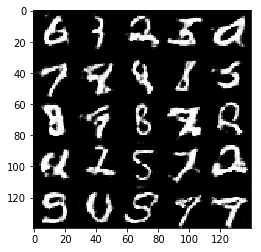

Discriminator Loss: 0.5133... Generator Loss: 1.5640
Discriminator Loss: 0.8419... Generator Loss: 0.8683
Discriminator Loss: 0.7304... Generator Loss: 0.9365
Discriminator Loss: 0.3638... Generator Loss: 1.6820
Discriminator Loss: 0.6936... Generator Loss: 0.9440
Discriminator Loss: 1.7479... Generator Loss: 0.2923
Discriminator Loss: 0.4952... Generator Loss: 1.4242
Discriminator Loss: 0.6017... Generator Loss: 1.1444
Discriminator Loss: 0.4507... Generator Loss: 1.2725
Discriminator Loss: 0.5358... Generator Loss: 2.9104


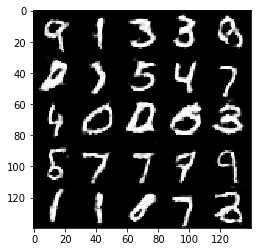

Discriminator Loss: 0.4297... Generator Loss: 1.8657
Discriminator Loss: 0.7748... Generator Loss: 0.8517
Discriminator Loss: 0.3994... Generator Loss: 1.5909
Discriminator Loss: 0.5703... Generator Loss: 1.1719
Discriminator Loss: 0.5534... Generator Loss: 1.2319
Discriminator Loss: 0.7749... Generator Loss: 0.9798
Discriminator Loss: 0.5124... Generator Loss: 2.4549
Discriminator Loss: 0.2508... Generator Loss: 2.9429
Discriminator Loss: 0.5944... Generator Loss: 1.1362
Discriminator Loss: 0.6963... Generator Loss: 0.8891


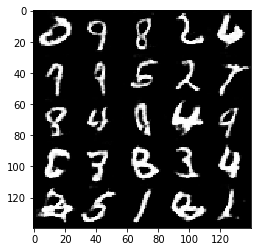

Discriminator Loss: 0.4782... Generator Loss: 1.6839
Discriminator Loss: 0.4026... Generator Loss: 2.1147
Discriminator Loss: 0.7216... Generator Loss: 1.0900
Discriminator Loss: 0.5975... Generator Loss: 1.2728
Discriminator Loss: 0.7002... Generator Loss: 1.0011
Discriminator Loss: 0.3730... Generator Loss: 1.6203
Discriminator Loss: 0.4691... Generator Loss: 1.4010
Discriminator Loss: 0.4340... Generator Loss: 1.6904
Discriminator Loss: 1.5128... Generator Loss: 0.3714
Discriminator Loss: 1.4118... Generator Loss: 0.4895


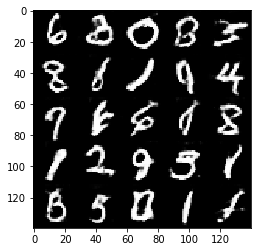

Discriminator Loss: 0.4667... Generator Loss: 1.6138
Discriminator Loss: 0.7821... Generator Loss: 1.0965
Discriminator Loss: 1.0165... Generator Loss: 0.6749
Discriminator Loss: 0.8261... Generator Loss: 0.8803
Discriminator Loss: 0.9342... Generator Loss: 0.7560
Discriminator Loss: 0.4899... Generator Loss: 1.4866
Discriminator Loss: 0.6312... Generator Loss: 1.5098
Discriminator Loss: 0.9226... Generator Loss: 0.7301
Discriminator Loss: 0.7320... Generator Loss: 1.0497
Discriminator Loss: 0.6694... Generator Loss: 1.0337


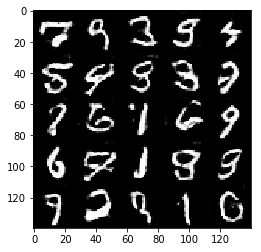

Discriminator Loss: 0.6844... Generator Loss: 1.4328
Discriminator Loss: 0.7476... Generator Loss: 0.9708
Discriminator Loss: 0.9966... Generator Loss: 0.7335
Discriminator Loss: 0.5985... Generator Loss: 1.7169
Discriminator Loss: 0.4374... Generator Loss: 1.7336
Discriminator Loss: 0.8203... Generator Loss: 0.9395
Discriminator Loss: 0.5175... Generator Loss: 1.5839
Discriminator Loss: 0.7351... Generator Loss: 0.9893
Discriminator Loss: 0.8706... Generator Loss: 0.7640
Discriminator Loss: 0.8585... Generator Loss: 0.8351


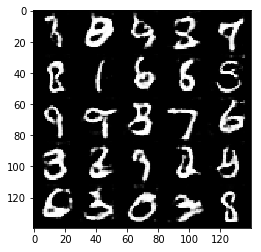

Discriminator Loss: 0.4494... Generator Loss: 1.4505
Discriminator Loss: 0.4437... Generator Loss: 1.4130
Discriminator Loss: 0.9519... Generator Loss: 0.7157
Discriminator Loss: 0.4697... Generator Loss: 1.2941
Discriminator Loss: 0.6248... Generator Loss: 1.2373
Discriminator Loss: 0.4435... Generator Loss: 1.3981
Discriminator Loss: 3.1522... Generator Loss: 0.0685
Discriminator Loss: 0.4240... Generator Loss: 1.5281
Discriminator Loss: 0.3493... Generator Loss: 1.9528
Discriminator Loss: 0.7673... Generator Loss: 0.8822


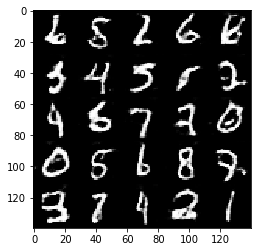

Discriminator Loss: 0.8468... Generator Loss: 0.7930
Discriminator Loss: 0.5398... Generator Loss: 1.1736
Discriminator Loss: 0.7316... Generator Loss: 0.9198
Discriminator Loss: 0.5507... Generator Loss: 1.5022
Discriminator Loss: 1.4012... Generator Loss: 0.5015
Discriminator Loss: 0.5766... Generator Loss: 1.3033
Discriminator Loss: 0.4317... Generator Loss: 1.9812
Discriminator Loss: 0.4451... Generator Loss: 1.9441
Discriminator Loss: 0.4283... Generator Loss: 2.4297
Discriminator Loss: 0.5343... Generator Loss: 1.9909


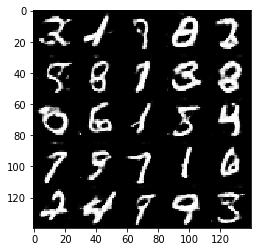

Discriminator Loss: 0.6665... Generator Loss: 1.0997
Discriminator Loss: 0.7388... Generator Loss: 0.8562
Discriminator Loss: 0.5723... Generator Loss: 1.1564
Discriminator Loss: 0.6349... Generator Loss: 1.1507
Discriminator Loss: 0.4169... Generator Loss: 1.7407
Discriminator Loss: 0.4783... Generator Loss: 1.4113
Discriminator Loss: 0.5558... Generator Loss: 1.3313
Discriminator Loss: 0.4788... Generator Loss: 1.4444
Discriminator Loss: 1.2644... Generator Loss: 0.6051
Discriminator Loss: 0.8610... Generator Loss: 1.0779


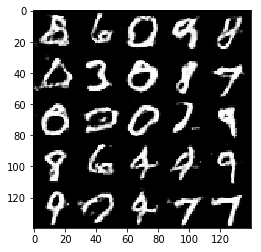

Discriminator Loss: 0.3366... Generator Loss: 1.7163
Discriminator Loss: 0.8209... Generator Loss: 1.1084
Discriminator Loss: 0.4174... Generator Loss: 1.3296
Discriminator Loss: 0.5266... Generator Loss: 1.2898
Discriminator Loss: 0.3470... Generator Loss: 1.7616
Discriminator Loss: 0.6716... Generator Loss: 1.0962
Discriminator Loss: 0.5507... Generator Loss: 1.3351
Discriminator Loss: 0.5520... Generator Loss: 1.2167
Discriminator Loss: 1.2167... Generator Loss: 0.5273
Discriminator Loss: 0.8952... Generator Loss: 0.7980


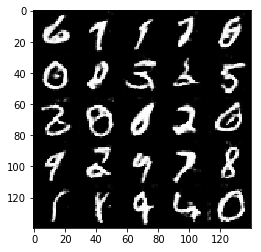

Discriminator Loss: 0.2232... Generator Loss: 2.2648
Discriminator Loss: 0.6021... Generator Loss: 1.0479
Discriminator Loss: 0.3492... Generator Loss: 1.7083
Discriminator Loss: 0.4606... Generator Loss: 1.7747
Discriminator Loss: 0.8774... Generator Loss: 0.7464


In [107]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Discriminator Loss: 1.9150... Generator Loss: 0.2249
Discriminator Loss: 0.6433... Generator Loss: 1.0279
Discriminator Loss: 0.4240... Generator Loss: 1.5800
Discriminator Loss: 0.1701... Generator Loss: 2.3442
Discriminator Loss: 0.5364... Generator Loss: 1.0192
Discriminator Loss: 0.1830... Generator Loss: 2.4217
Discriminator Loss: 0.2173... Generator Loss: 1.9905
Discriminator Loss: 0.0869... Generator Loss: 3.0011
Discriminator Loss: 0.1154... Generator Loss: 2.8374
Discriminator Loss: 0.1030... Generator Loss: 3.3590


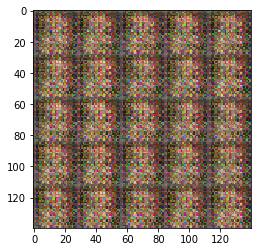

Discriminator Loss: 0.1202... Generator Loss: 2.7657
Discriminator Loss: 0.2809... Generator Loss: 1.5843
Discriminator Loss: 0.1549... Generator Loss: 5.0726
Discriminator Loss: 0.0551... Generator Loss: 5.3706
Discriminator Loss: 0.0822... Generator Loss: 4.2056
Discriminator Loss: 0.4346... Generator Loss: 1.4406
Discriminator Loss: 0.5728... Generator Loss: 1.5839
Discriminator Loss: 0.2938... Generator Loss: 1.7374
Discriminator Loss: 0.4975... Generator Loss: 1.1142
Discriminator Loss: 0.5983... Generator Loss: 1.2963


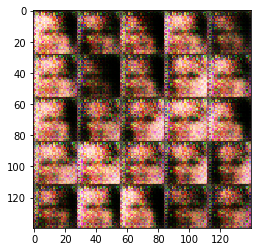

Discriminator Loss: 0.3930... Generator Loss: 2.5511
Discriminator Loss: 0.5292... Generator Loss: 2.8212
Discriminator Loss: 0.9114... Generator Loss: 0.8724
Discriminator Loss: 0.6515... Generator Loss: 1.7743
Discriminator Loss: 0.6319... Generator Loss: 2.6719
Discriminator Loss: 0.6304... Generator Loss: 1.0901
Discriminator Loss: 0.5996... Generator Loss: 1.3326
Discriminator Loss: 0.8123... Generator Loss: 1.0855
Discriminator Loss: 0.5607... Generator Loss: 1.2988
Discriminator Loss: 0.8695... Generator Loss: 0.6652


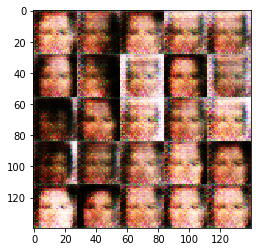

Discriminator Loss: 0.9299... Generator Loss: 0.8922
Discriminator Loss: 0.4972... Generator Loss: 1.4741
Discriminator Loss: 0.6705... Generator Loss: 1.2089
Discriminator Loss: 1.0544... Generator Loss: 0.9136
Discriminator Loss: 1.0608... Generator Loss: 0.7545
Discriminator Loss: 0.9219... Generator Loss: 1.7582
Discriminator Loss: 0.7618... Generator Loss: 1.1408
Discriminator Loss: 0.9796... Generator Loss: 1.1499
Discriminator Loss: 1.4435... Generator Loss: 0.6789
Discriminator Loss: 0.8143... Generator Loss: 1.3475


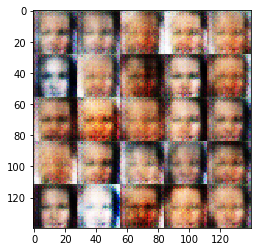

Discriminator Loss: 1.0641... Generator Loss: 0.8538
Discriminator Loss: 1.2132... Generator Loss: 0.8688
Discriminator Loss: 1.4563... Generator Loss: 0.5310
Discriminator Loss: 0.8964... Generator Loss: 1.2165
Discriminator Loss: 0.8983... Generator Loss: 0.9959
Discriminator Loss: 1.0537... Generator Loss: 0.8947
Discriminator Loss: 0.9260... Generator Loss: 1.0201
Discriminator Loss: 0.9925... Generator Loss: 1.0687
Discriminator Loss: 1.1099... Generator Loss: 0.9623
Discriminator Loss: 1.1714... Generator Loss: 1.0419


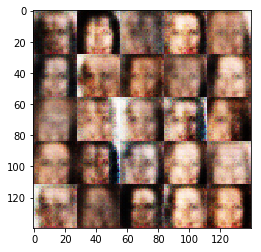

Discriminator Loss: 0.8695... Generator Loss: 1.1115
Discriminator Loss: 1.0531... Generator Loss: 0.8814
Discriminator Loss: 1.1936... Generator Loss: 0.7071
Discriminator Loss: 1.3360... Generator Loss: 0.6722
Discriminator Loss: 1.1711... Generator Loss: 0.9267
Discriminator Loss: 1.1021... Generator Loss: 0.8417
Discriminator Loss: 1.2564... Generator Loss: 0.8226
Discriminator Loss: 1.0242... Generator Loss: 0.9668
Discriminator Loss: 1.2601... Generator Loss: 0.6791
Discriminator Loss: 1.1061... Generator Loss: 0.9376


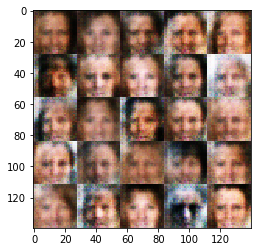

Discriminator Loss: 0.9234... Generator Loss: 1.0367
Discriminator Loss: 1.0475... Generator Loss: 0.7978
Discriminator Loss: 0.9138... Generator Loss: 0.9706
Discriminator Loss: 0.9918... Generator Loss: 0.9550
Discriminator Loss: 1.1263... Generator Loss: 0.9875
Discriminator Loss: 1.0768... Generator Loss: 0.7772
Discriminator Loss: 1.0664... Generator Loss: 0.8769
Discriminator Loss: 1.1053... Generator Loss: 0.6329
Discriminator Loss: 1.3383... Generator Loss: 0.8431
Discriminator Loss: 0.9756... Generator Loss: 1.1112


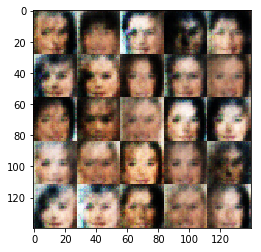

Discriminator Loss: 1.0538... Generator Loss: 0.9398
Discriminator Loss: 0.9457... Generator Loss: 1.2034
Discriminator Loss: 1.1878... Generator Loss: 0.9134
Discriminator Loss: 1.2763... Generator Loss: 0.6393
Discriminator Loss: 0.9303... Generator Loss: 0.9846
Discriminator Loss: 1.1454... Generator Loss: 0.8019
Discriminator Loss: 0.9497... Generator Loss: 1.0815
Discriminator Loss: 1.2466... Generator Loss: 0.7987
Discriminator Loss: 0.9637... Generator Loss: 1.1096
Discriminator Loss: 0.9422... Generator Loss: 1.1165


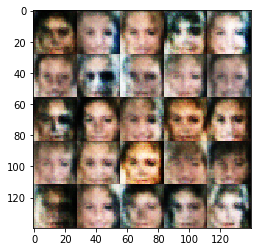

Discriminator Loss: 1.2006... Generator Loss: 0.7681
Discriminator Loss: 0.9910... Generator Loss: 0.9173
Discriminator Loss: 1.0054... Generator Loss: 0.9065
Discriminator Loss: 0.9203... Generator Loss: 1.1284
Discriminator Loss: 1.1676... Generator Loss: 0.8910
Discriminator Loss: 1.0942... Generator Loss: 0.8258
Discriminator Loss: 1.1225... Generator Loss: 0.7763
Discriminator Loss: 1.0350... Generator Loss: 0.7540
Discriminator Loss: 1.1309... Generator Loss: 0.8646
Discriminator Loss: 1.0078... Generator Loss: 0.8872


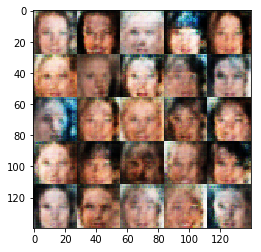

Discriminator Loss: 1.1264... Generator Loss: 0.8696
Discriminator Loss: 1.2303... Generator Loss: 0.6328
Discriminator Loss: 1.1903... Generator Loss: 0.7284
Discriminator Loss: 1.2246... Generator Loss: 0.6317
Discriminator Loss: 1.0905... Generator Loss: 0.8179
Discriminator Loss: 1.0650... Generator Loss: 0.8328
Discriminator Loss: 1.1278... Generator Loss: 0.8380
Discriminator Loss: 1.2493... Generator Loss: 0.8385
Discriminator Loss: 0.9301... Generator Loss: 0.9928
Discriminator Loss: 1.0659... Generator Loss: 0.8668


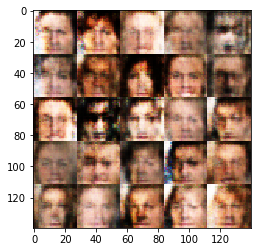

Discriminator Loss: 1.0799... Generator Loss: 1.0000
Discriminator Loss: 1.0908... Generator Loss: 0.8188
Discriminator Loss: 1.2380... Generator Loss: 0.6753
Discriminator Loss: 1.0732... Generator Loss: 1.0642
Discriminator Loss: 1.0866... Generator Loss: 0.9983
Discriminator Loss: 1.1165... Generator Loss: 0.8111
Discriminator Loss: 1.0517... Generator Loss: 1.0734
Discriminator Loss: 1.0150... Generator Loss: 0.7368
Discriminator Loss: 1.0685... Generator Loss: 0.9344
Discriminator Loss: 1.0592... Generator Loss: 0.7794


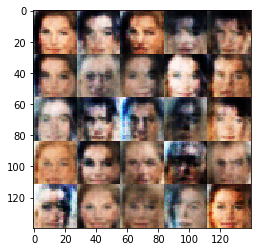

Discriminator Loss: 0.9935... Generator Loss: 1.1111
Discriminator Loss: 0.9890... Generator Loss: 1.0482
Discriminator Loss: 1.1358... Generator Loss: 0.8151
Discriminator Loss: 1.3903... Generator Loss: 0.5559
Discriminator Loss: 1.2646... Generator Loss: 0.6376
Discriminator Loss: 1.1904... Generator Loss: 0.7589
Discriminator Loss: 1.1694... Generator Loss: 0.7031
Discriminator Loss: 0.9391... Generator Loss: 0.9827
Discriminator Loss: 1.2765... Generator Loss: 0.7831
Discriminator Loss: 1.2459... Generator Loss: 0.8241


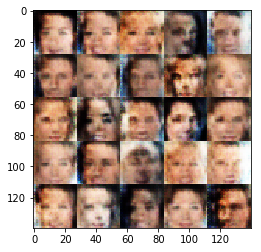

Discriminator Loss: 0.9022... Generator Loss: 0.9593
Discriminator Loss: 1.0583... Generator Loss: 0.7970
Discriminator Loss: 0.9363... Generator Loss: 0.9970
Discriminator Loss: 1.1286... Generator Loss: 0.8822
Discriminator Loss: 1.2247... Generator Loss: 0.7296
Discriminator Loss: 1.1601... Generator Loss: 0.8161
Discriminator Loss: 1.1100... Generator Loss: 0.9337
Discriminator Loss: 1.0535... Generator Loss: 0.8236
Discriminator Loss: 0.9783... Generator Loss: 0.8807
Discriminator Loss: 1.2746... Generator Loss: 0.8315


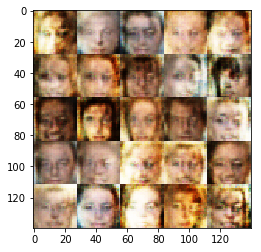

Discriminator Loss: 0.9575... Generator Loss: 0.8744
Discriminator Loss: 1.0626... Generator Loss: 0.9323
Discriminator Loss: 0.9262... Generator Loss: 1.1682
Discriminator Loss: 1.0546... Generator Loss: 0.8588
Discriminator Loss: 1.1095... Generator Loss: 0.7697
Discriminator Loss: 0.9534... Generator Loss: 1.0889
Discriminator Loss: 1.1800... Generator Loss: 0.7172
Discriminator Loss: 1.1699... Generator Loss: 0.8655
Discriminator Loss: 1.1737... Generator Loss: 0.8528
Discriminator Loss: 1.1115... Generator Loss: 0.7212


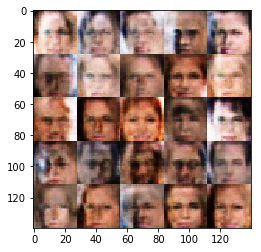

Discriminator Loss: 0.9886... Generator Loss: 0.9279
Discriminator Loss: 0.9218... Generator Loss: 0.9102
Discriminator Loss: 1.0325... Generator Loss: 1.0452
Discriminator Loss: 1.1487... Generator Loss: 0.8065
Discriminator Loss: 1.1351... Generator Loss: 0.8209
Discriminator Loss: 0.8240... Generator Loss: 1.0629
Discriminator Loss: 1.0548... Generator Loss: 1.0349
Discriminator Loss: 0.8596... Generator Loss: 1.0945
Discriminator Loss: 1.1574... Generator Loss: 0.6618
Discriminator Loss: 1.1248... Generator Loss: 0.8792


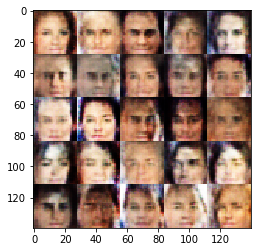

Discriminator Loss: 1.1060... Generator Loss: 0.8155
Discriminator Loss: 1.0105... Generator Loss: 1.0621
Discriminator Loss: 1.0762... Generator Loss: 0.7083
Discriminator Loss: 0.9331... Generator Loss: 0.8624
Discriminator Loss: 1.1019... Generator Loss: 0.8340
Discriminator Loss: 1.3274... Generator Loss: 0.6313
Discriminator Loss: 1.1279... Generator Loss: 0.9876
Discriminator Loss: 1.0298... Generator Loss: 0.9649
Discriminator Loss: 1.0246... Generator Loss: 0.8573
Discriminator Loss: 1.2066... Generator Loss: 0.6312


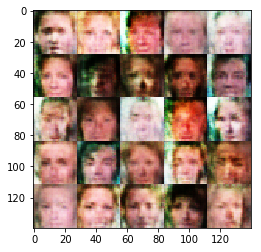

Discriminator Loss: 1.1703... Generator Loss: 0.6220
Discriminator Loss: 1.0412... Generator Loss: 0.9325
Discriminator Loss: 1.0750... Generator Loss: 1.0378
Discriminator Loss: 1.2046... Generator Loss: 0.6478
Discriminator Loss: 1.0404... Generator Loss: 0.8950
Discriminator Loss: 1.1611... Generator Loss: 0.8763
Discriminator Loss: 1.0181... Generator Loss: 0.9261
Discriminator Loss: 1.1146... Generator Loss: 0.8609
Discriminator Loss: 1.1693... Generator Loss: 0.6465
Discriminator Loss: 1.1685... Generator Loss: 0.8537


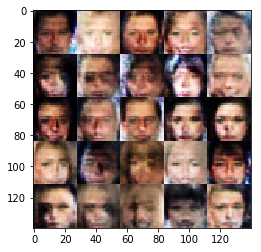

Discriminator Loss: 1.0404... Generator Loss: 0.9043
Discriminator Loss: 0.9353... Generator Loss: 0.9074
Discriminator Loss: 1.0298... Generator Loss: 0.7936
Discriminator Loss: 0.9665... Generator Loss: 1.0112
Discriminator Loss: 0.9059... Generator Loss: 1.1531
Discriminator Loss: 1.0524... Generator Loss: 0.8256
Discriminator Loss: 1.0322... Generator Loss: 0.7506
Discriminator Loss: 1.1010... Generator Loss: 0.9450
Discriminator Loss: 1.3792... Generator Loss: 0.4631
Discriminator Loss: 1.0412... Generator Loss: 0.8570


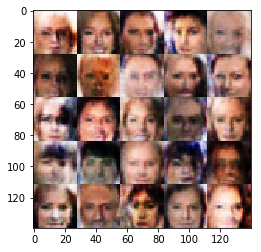

Discriminator Loss: 0.8762... Generator Loss: 0.9257
Discriminator Loss: 0.8886... Generator Loss: 1.1345
Discriminator Loss: 1.2020... Generator Loss: 0.9172
Discriminator Loss: 0.9211... Generator Loss: 0.8953
Discriminator Loss: 1.0481... Generator Loss: 0.8248
Discriminator Loss: 0.8883... Generator Loss: 1.1682
Discriminator Loss: 0.9436... Generator Loss: 1.0709
Discriminator Loss: 1.0824... Generator Loss: 0.8378
Discriminator Loss: 1.1540... Generator Loss: 0.7700
Discriminator Loss: 1.0388... Generator Loss: 0.9868


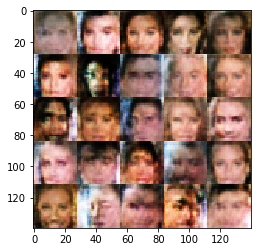

Discriminator Loss: 1.0745... Generator Loss: 0.8756
Discriminator Loss: 1.2989... Generator Loss: 0.5995
Discriminator Loss: 0.9993... Generator Loss: 0.7984
Discriminator Loss: 0.9995... Generator Loss: 0.8244
Discriminator Loss: 0.9444... Generator Loss: 1.1688
Discriminator Loss: 1.0573... Generator Loss: 0.8515
Discriminator Loss: 0.9719... Generator Loss: 1.3683
Discriminator Loss: 0.9659... Generator Loss: 1.1224
Discriminator Loss: 1.1688... Generator Loss: 0.8120
Discriminator Loss: 0.9903... Generator Loss: 0.9527


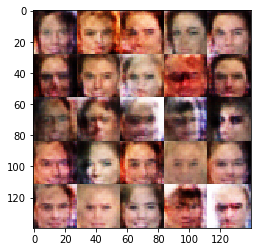

Discriminator Loss: 0.9610... Generator Loss: 1.0461
Discriminator Loss: 1.1672... Generator Loss: 0.8745
Discriminator Loss: 0.9720... Generator Loss: 0.9618
Discriminator Loss: 0.8846... Generator Loss: 1.0901
Discriminator Loss: 1.0770... Generator Loss: 0.8358
Discriminator Loss: 1.0632... Generator Loss: 0.9759
Discriminator Loss: 1.1278... Generator Loss: 0.7624
Discriminator Loss: 0.9429... Generator Loss: 0.8848
Discriminator Loss: 1.1088... Generator Loss: 0.8646
Discriminator Loss: 1.1673... Generator Loss: 0.7038


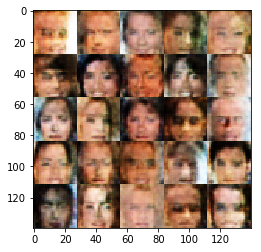

Discriminator Loss: 0.8638... Generator Loss: 0.9797
Discriminator Loss: 1.0503... Generator Loss: 0.7473
Discriminator Loss: 1.1261... Generator Loss: 0.8822
Discriminator Loss: 0.9949... Generator Loss: 0.8347
Discriminator Loss: 1.0113... Generator Loss: 0.9590
Discriminator Loss: 1.0263... Generator Loss: 0.9673
Discriminator Loss: 1.1407... Generator Loss: 0.8880
Discriminator Loss: 1.1499... Generator Loss: 0.7814
Discriminator Loss: 1.0482... Generator Loss: 0.8780
Discriminator Loss: 0.9774... Generator Loss: 0.8824


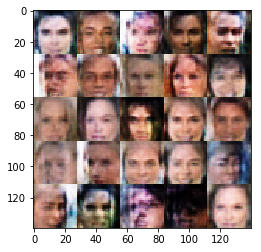

Discriminator Loss: 1.0317... Generator Loss: 0.8051
Discriminator Loss: 1.1073... Generator Loss: 0.9479
Discriminator Loss: 0.8821... Generator Loss: 1.0924
Discriminator Loss: 1.1697... Generator Loss: 0.8931
Discriminator Loss: 1.3009... Generator Loss: 0.5951
Discriminator Loss: 1.0545... Generator Loss: 0.8612
Discriminator Loss: 1.1168... Generator Loss: 0.8947
Discriminator Loss: 1.1209... Generator Loss: 0.7321
Discriminator Loss: 1.0547... Generator Loss: 0.9058
Discriminator Loss: 1.0060... Generator Loss: 0.8966


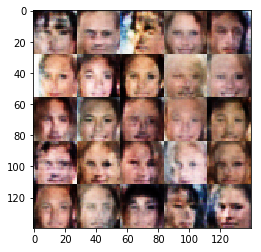

Discriminator Loss: 0.9968... Generator Loss: 0.8249
Discriminator Loss: 0.8034... Generator Loss: 1.3130
Discriminator Loss: 1.1025... Generator Loss: 0.7684
Discriminator Loss: 1.1278... Generator Loss: 0.9133
Discriminator Loss: 1.1425... Generator Loss: 0.6951
Discriminator Loss: 1.1969... Generator Loss: 0.6612
Discriminator Loss: 1.1133... Generator Loss: 0.7731
Discriminator Loss: 1.1414... Generator Loss: 0.7460
Discriminator Loss: 0.8740... Generator Loss: 0.9675
Discriminator Loss: 0.9981... Generator Loss: 0.8899


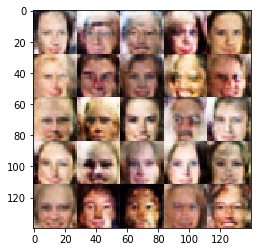

Discriminator Loss: 1.1911... Generator Loss: 0.6693
Discriminator Loss: 1.1388... Generator Loss: 0.6877
Discriminator Loss: 1.1301... Generator Loss: 0.7534
Discriminator Loss: 1.0299... Generator Loss: 0.7241
Discriminator Loss: 0.9256... Generator Loss: 1.0767
Discriminator Loss: 1.0923... Generator Loss: 0.7915
Discriminator Loss: 1.1313... Generator Loss: 0.6093
Discriminator Loss: 0.9116... Generator Loss: 0.9650
Discriminator Loss: 0.9672... Generator Loss: 0.9555
Discriminator Loss: 1.2329... Generator Loss: 0.7265


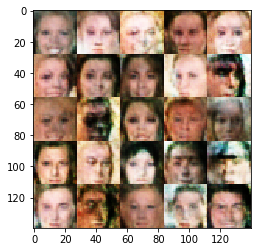

Discriminator Loss: 1.0386... Generator Loss: 0.7968
Discriminator Loss: 0.8517... Generator Loss: 0.9669
Discriminator Loss: 0.9290... Generator Loss: 1.0107
Discriminator Loss: 1.1905... Generator Loss: 0.6720
Discriminator Loss: 1.0850... Generator Loss: 0.6430
Discriminator Loss: 1.0928... Generator Loss: 0.9265
Discriminator Loss: 1.2267... Generator Loss: 0.5731
Discriminator Loss: 1.0800... Generator Loss: 0.8409
Discriminator Loss: 1.2253... Generator Loss: 0.5901
Discriminator Loss: 1.1297... Generator Loss: 1.0124


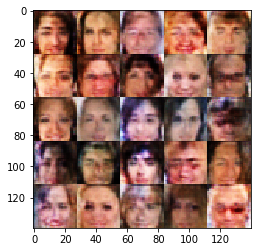

Discriminator Loss: 1.0897... Generator Loss: 0.7040
Discriminator Loss: 0.8517... Generator Loss: 0.9463
Discriminator Loss: 0.9222... Generator Loss: 1.2542
Discriminator Loss: 1.2526... Generator Loss: 0.8854
Discriminator Loss: 1.1196... Generator Loss: 0.7211
Discriminator Loss: 0.9485... Generator Loss: 1.0167
Discriminator Loss: 1.0431... Generator Loss: 0.9396
Discriminator Loss: 1.0905... Generator Loss: 0.9190
Discriminator Loss: 1.0207... Generator Loss: 0.8647
Discriminator Loss: 1.1380... Generator Loss: 0.8407


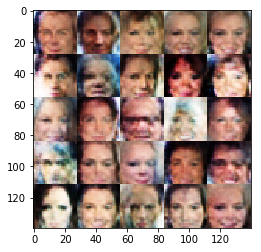

Discriminator Loss: 0.8571... Generator Loss: 1.0415
Discriminator Loss: 1.0797... Generator Loss: 0.8690
Discriminator Loss: 1.3356... Generator Loss: 0.6426
Discriminator Loss: 1.0400... Generator Loss: 0.8467
Discriminator Loss: 0.8821... Generator Loss: 0.8622
Discriminator Loss: 0.9753... Generator Loss: 0.9525
Discriminator Loss: 1.1469... Generator Loss: 0.6655
Discriminator Loss: 1.1354... Generator Loss: 0.7792
Discriminator Loss: 0.9251... Generator Loss: 0.7674
Discriminator Loss: 1.0832... Generator Loss: 0.9152


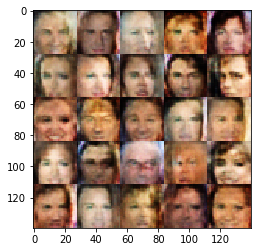

Discriminator Loss: 1.0066... Generator Loss: 0.9944
Discriminator Loss: 0.9990... Generator Loss: 0.8902
Discriminator Loss: 0.9701... Generator Loss: 0.9523
Discriminator Loss: 1.1893... Generator Loss: 0.6284
Discriminator Loss: 0.8194... Generator Loss: 1.0120
Discriminator Loss: 1.0385... Generator Loss: 0.8023
Discriminator Loss: 0.8371... Generator Loss: 1.0270
Discriminator Loss: 1.2314... Generator Loss: 0.6123
Discriminator Loss: 1.0996... Generator Loss: 0.7201
Discriminator Loss: 0.9077... Generator Loss: 1.3468


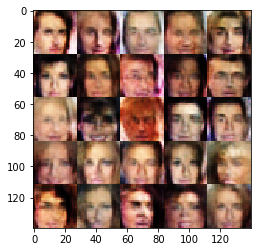

Discriminator Loss: 1.1523... Generator Loss: 0.7588
Discriminator Loss: 0.9923... Generator Loss: 0.8498
Discriminator Loss: 1.0224... Generator Loss: 0.9351
Discriminator Loss: 0.9684... Generator Loss: 1.0275
Discriminator Loss: 0.9115... Generator Loss: 1.1518
Discriminator Loss: 0.9758... Generator Loss: 1.1847
Discriminator Loss: 0.8592... Generator Loss: 0.9039
Discriminator Loss: 1.1536... Generator Loss: 1.0621
Discriminator Loss: 0.9782... Generator Loss: 0.9641
Discriminator Loss: 1.0090... Generator Loss: 0.9432


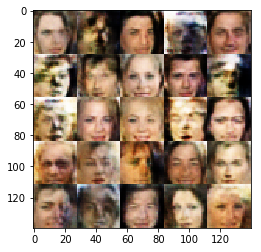

Discriminator Loss: 1.0805... Generator Loss: 0.6833
Discriminator Loss: 1.0416... Generator Loss: 0.8975
Discriminator Loss: 1.1003... Generator Loss: 0.8474
Discriminator Loss: 0.8787... Generator Loss: 1.0680
Discriminator Loss: 0.9249... Generator Loss: 1.1305
Discriminator Loss: 0.8853... Generator Loss: 0.9992
Discriminator Loss: 1.1881... Generator Loss: 0.7603
Discriminator Loss: 0.8379... Generator Loss: 1.4559
Discriminator Loss: 1.1745... Generator Loss: 0.6171
Discriminator Loss: 1.1305... Generator Loss: 0.6774


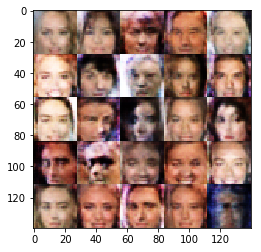

Discriminator Loss: 1.2591... Generator Loss: 0.5513
Discriminator Loss: 1.0488... Generator Loss: 0.7313
Discriminator Loss: 1.0292... Generator Loss: 1.0413
Discriminator Loss: 0.9814... Generator Loss: 0.9793
Discriminator Loss: 0.9567... Generator Loss: 1.1468
Discriminator Loss: 0.9135... Generator Loss: 0.9815
Discriminator Loss: 1.0971... Generator Loss: 0.8330
Discriminator Loss: 0.8608... Generator Loss: 1.1159
Discriminator Loss: 1.3155... Generator Loss: 0.4561
Discriminator Loss: 1.2653... Generator Loss: 0.5990


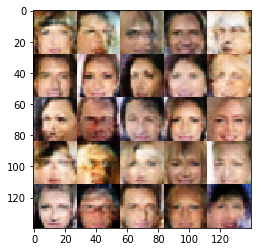

Discriminator Loss: 0.9532... Generator Loss: 1.1601
Discriminator Loss: 0.8321... Generator Loss: 1.1313
Discriminator Loss: 1.0333... Generator Loss: 0.7804
Discriminator Loss: 0.9766... Generator Loss: 0.8489
Discriminator Loss: 0.8867... Generator Loss: 1.2139
Discriminator Loss: 1.1600... Generator Loss: 0.8082
Discriminator Loss: 1.0481... Generator Loss: 0.7879
Discriminator Loss: 1.1150... Generator Loss: 0.7204
Discriminator Loss: 1.2798... Generator Loss: 0.7185
Discriminator Loss: 0.8905... Generator Loss: 0.9559


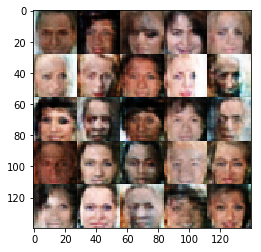

Discriminator Loss: 1.1367... Generator Loss: 0.7704
Discriminator Loss: 1.0133... Generator Loss: 1.0256
Discriminator Loss: 1.0648... Generator Loss: 0.6460
Discriminator Loss: 0.8668... Generator Loss: 0.8939
Discriminator Loss: 1.0816... Generator Loss: 0.6985
Discriminator Loss: 1.2453... Generator Loss: 0.6446
Discriminator Loss: 1.2253... Generator Loss: 0.5513
Discriminator Loss: 0.9643... Generator Loss: 1.1581
Discriminator Loss: 0.8502... Generator Loss: 1.2087
Discriminator Loss: 1.1045... Generator Loss: 0.7743


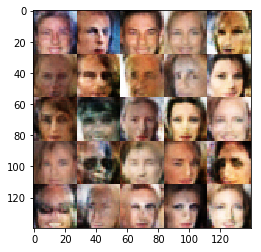

Discriminator Loss: 0.9703... Generator Loss: 0.8667
Discriminator Loss: 0.7694... Generator Loss: 1.0785
Discriminator Loss: 1.0100... Generator Loss: 0.8597
Discriminator Loss: 1.2069... Generator Loss: 0.8257
Discriminator Loss: 1.0769... Generator Loss: 0.6536
Discriminator Loss: 0.8973... Generator Loss: 0.8152
Discriminator Loss: 0.8502... Generator Loss: 1.0801
Discriminator Loss: 1.1855... Generator Loss: 0.7391
Discriminator Loss: 1.0184... Generator Loss: 1.0784
Discriminator Loss: 0.9313... Generator Loss: 0.8806


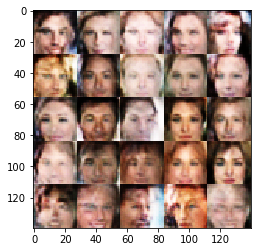

Discriminator Loss: 1.0314... Generator Loss: 0.9778
Discriminator Loss: 0.9666... Generator Loss: 0.9284
Discriminator Loss: 1.0906... Generator Loss: 0.7264
Discriminator Loss: 1.0344... Generator Loss: 0.7720
Discriminator Loss: 1.0748... Generator Loss: 0.8402
Discriminator Loss: 0.8872... Generator Loss: 1.2282
Discriminator Loss: 0.9632... Generator Loss: 0.8458
Discriminator Loss: 1.2168... Generator Loss: 0.6520
Discriminator Loss: 0.9924... Generator Loss: 0.7665
Discriminator Loss: 1.0260... Generator Loss: 0.9311


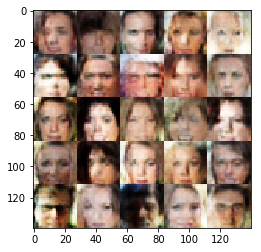

Discriminator Loss: 1.2611... Generator Loss: 0.4912
Discriminator Loss: 0.8741... Generator Loss: 1.2356
Discriminator Loss: 0.9594... Generator Loss: 0.9553
Discriminator Loss: 1.1897... Generator Loss: 0.6874
Discriminator Loss: 0.9532... Generator Loss: 0.8477
Discriminator Loss: 1.0013... Generator Loss: 0.8729
Discriminator Loss: 0.8222... Generator Loss: 1.1054
Discriminator Loss: 1.0211... Generator Loss: 1.1448
Discriminator Loss: 0.9557... Generator Loss: 0.9732
Discriminator Loss: 0.8893... Generator Loss: 0.9372


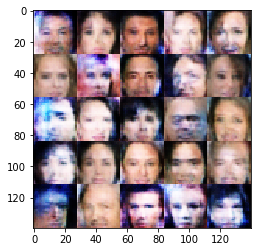

Discriminator Loss: 1.3140... Generator Loss: 0.6259
Discriminator Loss: 0.8874... Generator Loss: 1.0105
Discriminator Loss: 1.1551... Generator Loss: 0.7484
Discriminator Loss: 0.9702... Generator Loss: 1.4437
Discriminator Loss: 1.2916... Generator Loss: 0.6844
Discriminator Loss: 1.1798... Generator Loss: 0.6887
Discriminator Loss: 0.9827... Generator Loss: 0.9152
Discriminator Loss: 1.0241... Generator Loss: 1.0857
Discriminator Loss: 1.0290... Generator Loss: 0.9964
Discriminator Loss: 1.1790... Generator Loss: 0.8178


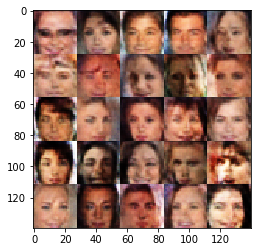

Discriminator Loss: 0.9690... Generator Loss: 0.8870
Discriminator Loss: 1.0133... Generator Loss: 0.8920
Discriminator Loss: 0.8853... Generator Loss: 1.1126
Discriminator Loss: 1.0699... Generator Loss: 0.8721
Discriminator Loss: 0.9398... Generator Loss: 0.9597
Discriminator Loss: 0.9107... Generator Loss: 1.1286
Discriminator Loss: 1.1527... Generator Loss: 0.8586
Discriminator Loss: 1.6591... Generator Loss: 0.4483
Discriminator Loss: 0.7603... Generator Loss: 1.1620
Discriminator Loss: 0.9199... Generator Loss: 1.1066


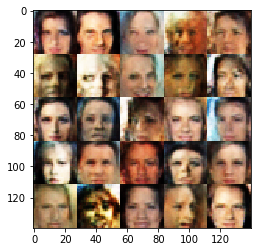

Discriminator Loss: 1.1304... Generator Loss: 0.7081
Discriminator Loss: 1.3261... Generator Loss: 0.6547
Discriminator Loss: 1.0309... Generator Loss: 0.9719
Discriminator Loss: 0.9471... Generator Loss: 1.0086
Discriminator Loss: 0.9554... Generator Loss: 0.8888
Discriminator Loss: 0.6825... Generator Loss: 1.2682
Discriminator Loss: 0.9049... Generator Loss: 1.0298
Discriminator Loss: 1.1898... Generator Loss: 0.8728
Discriminator Loss: 1.0101... Generator Loss: 0.8805
Discriminator Loss: 0.9405... Generator Loss: 1.0174


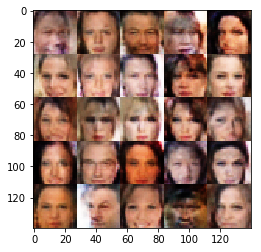

Discriminator Loss: 0.9475... Generator Loss: 0.7972
Discriminator Loss: 1.1189... Generator Loss: 0.6629
Discriminator Loss: 1.0598... Generator Loss: 0.8120
Discriminator Loss: 1.0008... Generator Loss: 0.9837
Discriminator Loss: 1.1593... Generator Loss: 0.7011
Discriminator Loss: 1.1528... Generator Loss: 0.7244
Discriminator Loss: 0.9391... Generator Loss: 0.8951
Discriminator Loss: 0.9446... Generator Loss: 0.9413
Discriminator Loss: 0.7954... Generator Loss: 0.9181
Discriminator Loss: 0.9786... Generator Loss: 0.8971


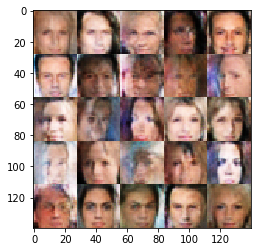

Discriminator Loss: 0.9234... Generator Loss: 0.8913
Discriminator Loss: 0.9427... Generator Loss: 0.8672
Discriminator Loss: 1.1754... Generator Loss: 0.7091
Discriminator Loss: 0.9699... Generator Loss: 0.9111
Discriminator Loss: 0.9130... Generator Loss: 0.9189
Discriminator Loss: 1.3591... Generator Loss: 0.9809
Discriminator Loss: 0.9061... Generator Loss: 0.8705
Discriminator Loss: 1.0530... Generator Loss: 0.6750
Discriminator Loss: 1.0158... Generator Loss: 0.9498
Discriminator Loss: 1.0198... Generator Loss: 0.7323


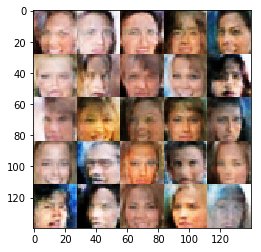

Discriminator Loss: 0.8239... Generator Loss: 1.0607
Discriminator Loss: 0.8138... Generator Loss: 1.3681
Discriminator Loss: 0.9737... Generator Loss: 1.0136
Discriminator Loss: 1.1095... Generator Loss: 0.8692
Discriminator Loss: 0.7824... Generator Loss: 0.9030
Discriminator Loss: 0.8343... Generator Loss: 1.0467
Discriminator Loss: 1.0185... Generator Loss: 0.9587
Discriminator Loss: 1.0779... Generator Loss: 0.8398
Discriminator Loss: 1.0245... Generator Loss: 0.7270
Discriminator Loss: 1.1445... Generator Loss: 0.6593


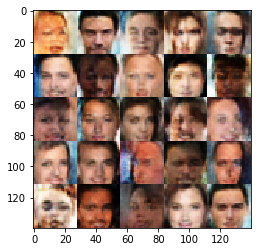

Discriminator Loss: 0.9817... Generator Loss: 0.9228
Discriminator Loss: 1.1286... Generator Loss: 0.5450
Discriminator Loss: 0.9513... Generator Loss: 0.9238
Discriminator Loss: 1.1252... Generator Loss: 0.7045
Discriminator Loss: 0.8854... Generator Loss: 0.9787
Discriminator Loss: 1.1950... Generator Loss: 0.5811
Discriminator Loss: 1.1213... Generator Loss: 0.6563
Discriminator Loss: 1.0829... Generator Loss: 0.8055
Discriminator Loss: 1.1480... Generator Loss: 0.6508
Discriminator Loss: 0.9641... Generator Loss: 0.8034


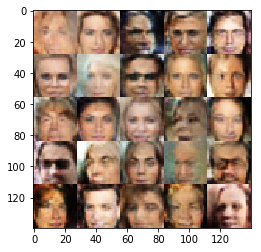

Discriminator Loss: 1.0431... Generator Loss: 0.8159
Discriminator Loss: 0.9306... Generator Loss: 1.0074
Discriminator Loss: 1.0109... Generator Loss: 0.8373
Discriminator Loss: 1.1868... Generator Loss: 0.5698
Discriminator Loss: 1.0365... Generator Loss: 0.8314
Discriminator Loss: 1.2656... Generator Loss: 0.6469
Discriminator Loss: 1.1624... Generator Loss: 0.6472
Discriminator Loss: 1.0664... Generator Loss: 0.8084
Discriminator Loss: 1.1352... Generator Loss: 0.6494
Discriminator Loss: 0.9854... Generator Loss: 0.8070


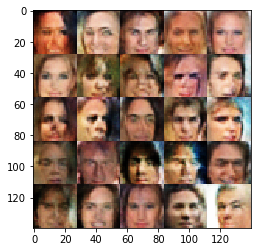

Discriminator Loss: 0.9777... Generator Loss: 0.9277
Discriminator Loss: 0.9599... Generator Loss: 0.9383
Discriminator Loss: 0.9857... Generator Loss: 0.7665
Discriminator Loss: 0.7652... Generator Loss: 1.0455
Discriminator Loss: 0.9533... Generator Loss: 1.4273
Discriminator Loss: 0.9882... Generator Loss: 0.8359
Discriminator Loss: 0.7916... Generator Loss: 0.9911
Discriminator Loss: 0.7637... Generator Loss: 1.3323
Discriminator Loss: 0.9213... Generator Loss: 1.2351
Discriminator Loss: 0.9673... Generator Loss: 1.0919


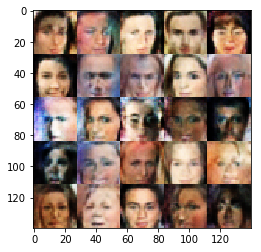

Discriminator Loss: 1.1163... Generator Loss: 0.6622
Discriminator Loss: 0.9739... Generator Loss: 0.9619
Discriminator Loss: 0.8609... Generator Loss: 0.9490
Discriminator Loss: 0.9853... Generator Loss: 1.2712
Discriminator Loss: 0.9413... Generator Loss: 0.8354
Discriminator Loss: 0.9293... Generator Loss: 0.8808
Discriminator Loss: 0.8389... Generator Loss: 0.9943
Discriminator Loss: 1.0612... Generator Loss: 0.6725
Discriminator Loss: 1.0915... Generator Loss: 0.7032
Discriminator Loss: 1.1406... Generator Loss: 0.6085


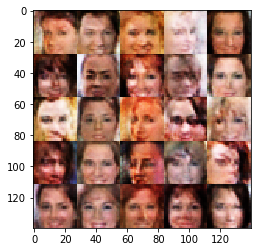

Discriminator Loss: 0.8192... Generator Loss: 0.8927
Discriminator Loss: 1.0321... Generator Loss: 0.6573
Discriminator Loss: 0.8391... Generator Loss: 1.3181
Discriminator Loss: 1.0564... Generator Loss: 0.6303
Discriminator Loss: 0.9374... Generator Loss: 0.9442
Discriminator Loss: 0.9946... Generator Loss: 0.9322
Discriminator Loss: 1.1061... Generator Loss: 0.6951
Discriminator Loss: 1.1062... Generator Loss: 0.7938
Discriminator Loss: 0.9182... Generator Loss: 1.5412
Discriminator Loss: 0.9488... Generator Loss: 0.8378


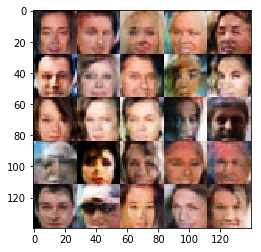

Discriminator Loss: 1.0052... Generator Loss: 0.8736
Discriminator Loss: 1.1358... Generator Loss: 0.7490
Discriminator Loss: 0.9118... Generator Loss: 0.9733
Discriminator Loss: 1.0667... Generator Loss: 0.7161
Discriminator Loss: 1.0166... Generator Loss: 0.8455
Discriminator Loss: 1.0777... Generator Loss: 0.6511
Discriminator Loss: 1.0230... Generator Loss: 0.9150
Discriminator Loss: 0.7176... Generator Loss: 1.3632
Discriminator Loss: 0.9310... Generator Loss: 0.9331
Discriminator Loss: 1.1080... Generator Loss: 0.6777


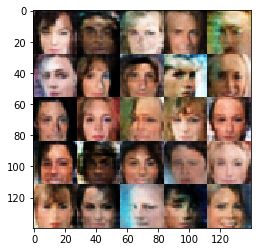

Discriminator Loss: 1.0768... Generator Loss: 0.8841
Discriminator Loss: 1.1434... Generator Loss: 0.6355
Discriminator Loss: 1.0978... Generator Loss: 0.7089
Discriminator Loss: 0.9851... Generator Loss: 0.8086
Discriminator Loss: 1.0693... Generator Loss: 0.7698
Discriminator Loss: 0.9490... Generator Loss: 0.8928
Discriminator Loss: 0.9329... Generator Loss: 0.8183
Discriminator Loss: 0.9523... Generator Loss: 0.8112
Discriminator Loss: 0.8150... Generator Loss: 1.0057
Discriminator Loss: 1.0088... Generator Loss: 0.8475


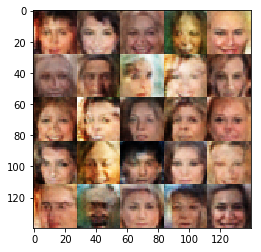

Discriminator Loss: 1.0288... Generator Loss: 0.7125
Discriminator Loss: 1.4877... Generator Loss: 0.4703
Discriminator Loss: 1.0858... Generator Loss: 0.6817
Discriminator Loss: 1.0615... Generator Loss: 0.6474
Discriminator Loss: 0.9192... Generator Loss: 1.1187
Discriminator Loss: 0.8132... Generator Loss: 1.0153
Discriminator Loss: 1.1920... Generator Loss: 0.8490
Discriminator Loss: 1.1375... Generator Loss: 0.8437
Discriminator Loss: 1.1230... Generator Loss: 0.7937
Discriminator Loss: 1.0767... Generator Loss: 1.0179


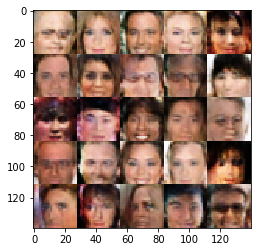

Discriminator Loss: 1.0076... Generator Loss: 0.6620
Discriminator Loss: 0.9548... Generator Loss: 0.7678
Discriminator Loss: 1.2090... Generator Loss: 0.6316
Discriminator Loss: 0.9326... Generator Loss: 0.9912
Discriminator Loss: 1.0440... Generator Loss: 0.7258
Discriminator Loss: 1.0921... Generator Loss: 0.8270
Discriminator Loss: 0.8872... Generator Loss: 0.9483
Discriminator Loss: 1.1206... Generator Loss: 0.6452
Discriminator Loss: 1.0792... Generator Loss: 0.6489
Discriminator Loss: 1.0306... Generator Loss: 0.9609


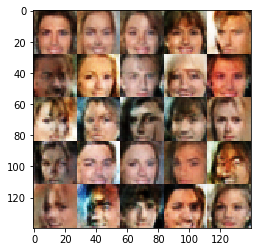

Discriminator Loss: 0.8547... Generator Loss: 0.9232
Discriminator Loss: 0.9324... Generator Loss: 0.8750
Discriminator Loss: 1.2063... Generator Loss: 0.5766
Discriminator Loss: 0.9474... Generator Loss: 0.9238
Discriminator Loss: 1.2417... Generator Loss: 0.6267
Discriminator Loss: 0.7608... Generator Loss: 0.9401
Discriminator Loss: 0.7975... Generator Loss: 1.1723
Discriminator Loss: 1.0762... Generator Loss: 0.6807
Discriminator Loss: 1.0135... Generator Loss: 0.6073
Discriminator Loss: 0.9577... Generator Loss: 1.1001


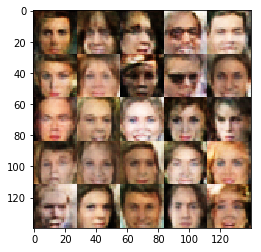

Discriminator Loss: 1.0827... Generator Loss: 0.8020
Discriminator Loss: 0.8524... Generator Loss: 1.0955
Discriminator Loss: 1.3501... Generator Loss: 0.4258
Discriminator Loss: 1.1912... Generator Loss: 0.6405
Discriminator Loss: 0.8575... Generator Loss: 1.0583
Discriminator Loss: 1.0666... Generator Loss: 0.8178
Discriminator Loss: 0.8556... Generator Loss: 1.1204
Discriminator Loss: 1.0262... Generator Loss: 0.8476
Discriminator Loss: 1.0064... Generator Loss: 0.7974
Discriminator Loss: 0.9489... Generator Loss: 0.8091


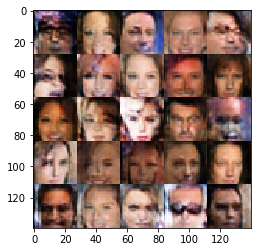

Discriminator Loss: 0.9779... Generator Loss: 0.7943
Discriminator Loss: 1.0084... Generator Loss: 0.9177
Discriminator Loss: 1.1526... Generator Loss: 0.7182
Discriminator Loss: 1.2200... Generator Loss: 0.5722
Discriminator Loss: 1.0976... Generator Loss: 0.6913
Discriminator Loss: 1.3834... Generator Loss: 0.6086
Discriminator Loss: 0.9033... Generator Loss: 0.9109
Discriminator Loss: 1.5459... Generator Loss: 0.4017
Discriminator Loss: 1.1203... Generator Loss: 0.7231
Discriminator Loss: 1.0184... Generator Loss: 0.7750


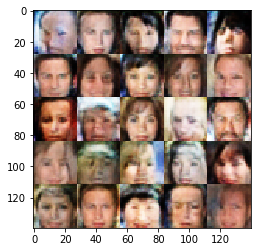

Discriminator Loss: 1.4037... Generator Loss: 0.4088
Discriminator Loss: 1.2386... Generator Loss: 0.8034
Discriminator Loss: 1.4482... Generator Loss: 0.4698
Discriminator Loss: 0.9681... Generator Loss: 0.9177
Discriminator Loss: 1.2805... Generator Loss: 0.5496
Discriminator Loss: 1.0149... Generator Loss: 0.9356
Discriminator Loss: 0.7538... Generator Loss: 1.1990
Discriminator Loss: 1.0220... Generator Loss: 0.5990
Discriminator Loss: 1.1487... Generator Loss: 0.8143
Discriminator Loss: 0.8912... Generator Loss: 0.9880


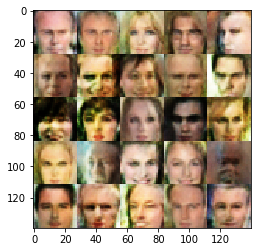

Discriminator Loss: 0.9235... Generator Loss: 0.8435
Discriminator Loss: 1.3879... Generator Loss: 0.4544
Discriminator Loss: 0.8942... Generator Loss: 0.8817
Discriminator Loss: 0.9219... Generator Loss: 1.0568
Discriminator Loss: 1.1678... Generator Loss: 0.6100
Discriminator Loss: 0.8234... Generator Loss: 0.9302
Discriminator Loss: 0.7798... Generator Loss: 1.1764
Discriminator Loss: 0.8234... Generator Loss: 1.3926
Discriminator Loss: 1.0994... Generator Loss: 0.7309
Discriminator Loss: 0.9092... Generator Loss: 1.0885


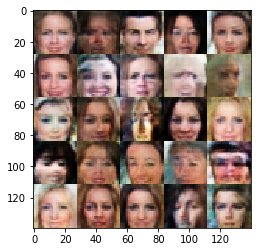

Discriminator Loss: 0.9196... Generator Loss: 0.8969
Discriminator Loss: 0.7653... Generator Loss: 1.1923
Discriminator Loss: 1.2915... Generator Loss: 0.5709
Discriminator Loss: 1.2402... Generator Loss: 0.5697
Discriminator Loss: 1.1418... Generator Loss: 0.9470
Discriminator Loss: 0.9866... Generator Loss: 0.7676
Discriminator Loss: 1.0646... Generator Loss: 0.7845
Discriminator Loss: 0.9892... Generator Loss: 1.0084
Discriminator Loss: 1.2995... Generator Loss: 0.5973
Discriminator Loss: 1.1543... Generator Loss: 0.6221


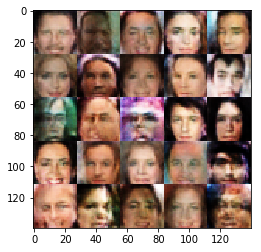

Discriminator Loss: 0.9471... Generator Loss: 0.7075
Discriminator Loss: 1.2777... Generator Loss: 0.6865
Discriminator Loss: 1.0721... Generator Loss: 0.8428
Discriminator Loss: 0.8353... Generator Loss: 1.0031
Discriminator Loss: 1.0533... Generator Loss: 0.6963
Discriminator Loss: 0.7773... Generator Loss: 1.1199
Discriminator Loss: 1.1187... Generator Loss: 0.7125
Discriminator Loss: 0.9791... Generator Loss: 0.7580
Discriminator Loss: 1.1199... Generator Loss: 0.8562
Discriminator Loss: 0.7731... Generator Loss: 1.0808


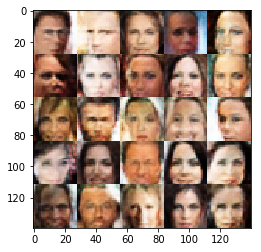

Discriminator Loss: 0.7427... Generator Loss: 1.2527
Discriminator Loss: 0.8888... Generator Loss: 0.9729
Discriminator Loss: 0.7488... Generator Loss: 1.1737
Discriminator Loss: 0.8252... Generator Loss: 0.8826
Discriminator Loss: 1.1085... Generator Loss: 0.7735
Discriminator Loss: 1.2532... Generator Loss: 0.5660
Discriminator Loss: 1.0107... Generator Loss: 0.8533
Discriminator Loss: 1.1050... Generator Loss: 0.6374
Discriminator Loss: 1.0350... Generator Loss: 0.7275
Discriminator Loss: 1.2446... Generator Loss: 0.5908


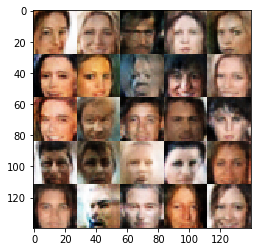

Discriminator Loss: 1.2528... Generator Loss: 0.6778
Discriminator Loss: 0.8115... Generator Loss: 1.1122
Discriminator Loss: 1.0031... Generator Loss: 0.7077
Discriminator Loss: 0.9938... Generator Loss: 0.7756
Discriminator Loss: 1.2871... Generator Loss: 0.6300
Discriminator Loss: 0.9577... Generator Loss: 1.0237
Discriminator Loss: 1.0955... Generator Loss: 0.7022
Discriminator Loss: 1.2419... Generator Loss: 0.6360
Discriminator Loss: 1.0770... Generator Loss: 0.6737
Discriminator Loss: 0.8676... Generator Loss: 0.9950


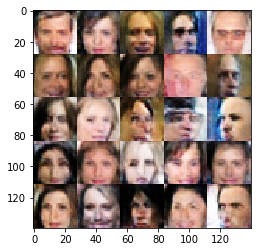

Discriminator Loss: 1.2184... Generator Loss: 0.7083
Discriminator Loss: 1.1248... Generator Loss: 0.6535
Discriminator Loss: 1.2468... Generator Loss: 0.6692
Discriminator Loss: 1.0368... Generator Loss: 0.8461
Discriminator Loss: 0.6933... Generator Loss: 1.1524
Discriminator Loss: 0.9033... Generator Loss: 1.0069
Discriminator Loss: 1.0246... Generator Loss: 0.7586
Discriminator Loss: 0.9454... Generator Loss: 1.0210
Discriminator Loss: 1.1596... Generator Loss: 0.6569
Discriminator Loss: 1.1882... Generator Loss: 0.5973


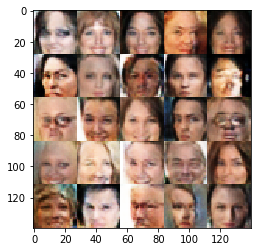

Discriminator Loss: 1.1556... Generator Loss: 0.6760
Discriminator Loss: 1.2368... Generator Loss: 0.5135
Discriminator Loss: 0.9377... Generator Loss: 1.0637
Discriminator Loss: 0.9887... Generator Loss: 0.8618
Discriminator Loss: 1.2553... Generator Loss: 0.5882
Discriminator Loss: 1.1955... Generator Loss: 0.7007
Discriminator Loss: 0.9181... Generator Loss: 0.9315
Discriminator Loss: 0.9903... Generator Loss: 0.9683
Discriminator Loss: 1.0492... Generator Loss: 0.7792
Discriminator Loss: 1.2197... Generator Loss: 0.5495


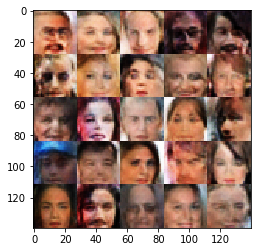

Discriminator Loss: 0.8788... Generator Loss: 1.0984
Discriminator Loss: 1.1242... Generator Loss: 0.8158
Discriminator Loss: 0.8780... Generator Loss: 0.9368


In [108]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.